# Competitors

30 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [43]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm
import h3
import os

from scipy.spatial import KDTree
import scipy.sparse as sp
from scipy import io
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, HDBSCAN
from INEGIpy import MarcoGeoestadistico

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# cluster for trails
CLUSTERS_TRIALS = [7, 19, 23] # qro, cancun, cuernavaca

# subset
gdf_properties = gdf_properties[gdf_properties['city_cluster'].isin(CLUSTERS_TRIALS)]

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 136194 entries, 50 to 1909937
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   half_bathrooms                      136194 non-null  uint8         
 1   full_bathrooms                      136194 non-null  uint8         
 2   property_class_more_common_in_area  136194 non-null  string        
 3   neighborhood                        136194 non-null  string        
 4   constructor                         136133 non-null  string        
 5   zip_code                            136194 non-null  uint32        
 6   age_in_months                       136194 non-null  uint8         
 7   parking_lots                        136194 non-null  uint8         
 8   valuation_date                      136194 non-null  datetime64[ns]
 9   potable_water_service_id            88375 non-null   float64       
 10  lig

In [50]:
# print property_id unique
print(gdf_properties['property_id'].nunique())
print(gdf_properties['observation_id'].nunique())

133355
136194


## Cities

In [4]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

# look
gdf_cities

,geometry,cluster,total_properties
0,"POLYGON ((3766192.137 1038920.719, 3766072.241...",0,49294
1,"POLYGON ((2106201.674 1838908.292, 2106105.496...",1,41078
2,"POLYGON ((2083964.935 2167068.796, 2083854.591...",2,49914
3,"POLYGON ((3695976.760 913468.113, 3695883.500 ...",3,4945
4,"POLYGON ((2691489.214 1478562.321, 2691414.834...",4,224732
...,...,...,...
109,"POLYGON ((2809075.793 1188762.402, 2808986.206...",109,1570
110,"POLYGON ((2652237.387 1032197.642, 2652132.900...",110,1158
111,"POLYGON ((2608508.314 1013348.771, 2608407.574...",111,1402
112,"POLYGON ((2401691.811 1520986.348, 2401617.754...",112,1189


In [5]:
# see map
gdf_cities.explore(tiles="cartodbpositron")

## Wrangle

In [33]:
# wrangle
gdf_properties = (
    gdf_properties
    # new vars
    .assign(
        property_type=lambda x: np.where(x['property_type_id'].le(3), 'house', 'apartment'),
        longitude=lambda x: x["geometry"].x,
        latitude=lambda x: x["geometry"].y,
        parking_lots=lambda x: x["parking_lots"].fillna(0),
        price_per_sqm=lambda x: x["price"] / x["saleable_area"],
        log_price_per_sqm=lambda x: np.log(x["price_per_sqm"]),
    )
    .reset_index(drop=True)
    # categorize variables for comparisson
    .assign(
        bedrooms_cat=lambda x: np.select(
            [
                x["bedrooms"].le(1),
                x["bedrooms"].le(2),
                x["bedrooms"].le(3),
                x["bedrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        full_bathrooms_cat=lambda x: np.select(
            [
                x["full_bathrooms"].le(1),
                x["full_bathrooms"].le(2),
                x["full_bathrooms"].le(3),
                x["full_bathrooms"].gt(3),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        max_total_levels=lambda x:
            x[['level', 'total_levels']].max(axis=1),
        max_total_levels=lambda x: np.select(
            [
                x["max_total_levels"].le(1),
                x["max_total_levels"].le(5),
                x["max_total_levels"].le(15),
                x["max_total_levels"].gt(15),
            ],
            [
                1, 2, 3, 4
            ],
            default=0
        ),
        elevator_service_id_cat=lambda x:
            np.where(x['elevator_service_id'].eq(1), 1, 0),
        parking_lots_cat=lambda x: np.select(
            [
                x["parking_lots"].le(0),
                x["parking_lots"].le(1),
                x["parking_lots"].le(2),
                x["parking_lots"].gt(2),
            ],
            [
                0, 1, 2, 3
            ],
            default=0
        ),
    )
)   

## Mini EDA

In [34]:
# see cat vars description
(
    gdf_properties
    .filter(like="_cat")
    .apply(pd.Series.value_counts)
    .div(gdf_properties.shape[0])
)

,bedrooms_cat,full_bathrooms_cat,niveles_cat,elevator_service_id_cat,parking_lots_cat
0,NaN,NaN,NaN,0.967304,0.135424
1,0.048725,0.531859,0.001072,0.032696,0.583080
2,0.510962,0.314096,0.934131,NaN,0.260878
3,0.396662,0.109968,0.062198,NaN,0.020618
4,0.043651,0.044077,0.002599,NaN,NaN


In [35]:
# see how many properties didnt join
gdf_properties["city_cluster"].isna().sum()

0

In [36]:
# if there is a index repeated
gdf_properties.index.duplicated().sum()

0

---
# Get Competitors

## S1: Calculate

In [135]:
# functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

def get_neighbors_properties(gdf, r=1):
    # copy
    gdf = gdf.copy()

    # fit kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )

    # get neighbors at r-km
    return kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1
    )

def get_possible_neighbors(df_own, df_theirs, vars_list):
    # Select only relevant columns and explode neighbors_list column in df_own
    df_own_expanded = (
        df_own
        .loc[:, vars_list + ['neighbors_list']]
        .explode('neighbors_list')  # Expands neighbors_list into multiple rows
        .rename(columns={'neighbors_list': 'id_neighbor'})  # Rename for merge clarity
        .reset_index()  # Reset index to use in merging
    )

    # Prepare df_theirs for merging by keeping track of original indexes
    df_theirs_indexed = (
        df_theirs
        .assign(index=lambda x: x.index)  # Add index column for merging
        .loc[:, ['index'] + vars_list]  # Select only relevant columns
    )

    # Merge expanded df_own with df_theirs based on neighbor IDs
    merged_df = df_own_expanded.merge(
        df_theirs_indexed,
        how='inner',
        left_on='id_neighbor',  # Match on the id_neighbor column from df_own
        right_on='index',  # Match on index from df_theirs
        suffixes=('_own', '_neighbor')
    )

    # Filter out rows where observation_id_own is the same as observation_id_neighbor
    result_df = merged_df.query("observation_id_own != observation_id_neighbor", engine='python')
    
    return result_df


# get distance
def find_competitors(gdf):
    # Step 1: Distance
    gdf_distance = (
        gdf.copy()
        # distances: TODO: Check distributions
        .assign(
            # geo distance
            geo_distance=lambda x: np.sqrt(
                (x['longitude_own'] - x['longitude_neighbor'])**2
                + (x['latitude_own'] - x['latitude_neighbor'])**2
            ),
            # topology distance
            terrain_distance=lambda x: np.sqrt(
                (x['land_area_neighbor'] - x['land_area_own'])**2
            ),
            built_distance=lambda x: np.sqrt(
                (x['built_area_neighbor'] - x['built_area_own'])**2
            ),
            # conservation
            conservation_distance=lambda x: np.sqrt(
                (x['age_in_months_own'] - x['age_in_months_neighbor'])**2
            ),
            # characteristics distance
            characteristics_distance=lambda x: np.sqrt(
                (x['elevator_service_id_cat_own'] - x['elevator_service_id_cat_neighbor'])**2
                + (x['max_total_levels_own'] - x['max_total_levels_neighbor'])**2
                + (x['bedrooms_cat_own'] - x['bedrooms_cat_neighbor'])**2
                + (x['full_bathrooms_cat_own'] - x['full_bathrooms_cat_neighbor'])**2
                + (x['parking_lots_cat_own'] - x['parking_lots_cat_neighbor'])**2
            ),
            # time distance
            time_distance=lambda x: np.sqrt(
                ((x['valuation_date_own'] - x['valuation_date_neighbor']).dt.days / (365 * 2))**2
            ),
        )
        # filter out those that are more than a year apart
        .query("time_distance.le(1)")
        # normalize distances
        .assign(
            geo_distance_norm=lambda x: min_max(x['geo_distance']),
            terrain_distance_norm=lambda x: min_max(x['terrain_distance']),
            built_distance_norm=lambda x: min_max(x['built_distance']),
            conservation_distance_norm=lambda x: min_max(x['conservation_distance']),
            characteristics_distance_norm=lambda x: min_max(x['characteristics_distance']),
            time_distance_norm=lambda x: min_max(x['time_distance'])
        )
        # total distance
        .assign(
            total_distance=lambda x: (
                x['geo_distance_norm'] * GEO_WEIGHT
                + x['terrain_distance_norm'] * TERRAIN_WEIGHT
                + x['built_distance_norm'] * BUILT_WEIGHT
                + x['conservation_distance_norm'] * CONSERVATION_WEIGHT
                + x['characteristics_distance_norm'] * CHAR_WEIGHT
                + x['time_distance_norm'] * TIME_WEIGHT
            )
        )
        # eliminate 0s in the distance to avoid comparing to itself
        .query("total_distance.gt(0)")
    )

    # Step 2: Aggregation
    df_comps = (
        gdf_distance
        .assign(
            index_distance_tuple=lambda x: list(zip(x['observation_id_neighbor'], x['total_distance'])),
        )
        .groupby('observation_id_own', as_index=False)
        .agg(
            neighbors_list=('index_distance_tuple', list),
            num_neighbors=('observation_id_neighbor', 'count'),
        )
    )
    return df_comps


# function to orchestrate the process
def get_competitors(gdf, property_type='apartment', city=0, batch_size=None, radius=1):
    # params
    cols_to_stay = [
        # variables to stay
        'observation_id',
        # geographic
        'longitude', 'latitude',
        # topology
        'land_area', 'built_area',
        # characteristics
        'elevator_service_id_cat', 'max_total_levels', 'remaining_useful_life_cat', 
        'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
        # time
        'valuation_date',
    ]

    # subset 
    gdf_work = (
        gdf
        .query("city_cluster.eq(@city) & property_type.eq(@property_type)", engine='python')
        .reset_index(drop=True)
        .copy()
    )

    # check if there are properties
    if gdf_work.shape[0] == 0:
        return pd.DataFrame()

    # get neighbors
    gdf_work['neighbors_list'] = get_neighbors_properties(gdf_work, r=radius)

    # get possible neighbors by batch
    n_batches = gdf_work.shape[0] // batch_size
    if n_batches > 0:
        batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
    else:
        batch_indexes = [gdf_work.index]

    gdf_neighbors_list = []
    for batch in batch_indexes:
        # print batch
        # get possible neighbors
        gdf_neighbors_info = get_possible_neighbors(
            df_own=gdf_work.loc[batch],
            df_theirs=gdf_work,
            vars_list=cols_to_stay
        )
        # find competitors
        gdf_neighbors_subset = find_competitors(gdf_neighbors_info)
        # append
        gdf_neighbors_list.append(gdf_neighbors_subset)

    # concatenate
    gdf_neighbors = pd.concat(gdf_neighbors_list)
    
    return gdf_neighbors

### Manually

In [137]:
# PARAMS
# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.1
BUILT_WEIGHT = 0.2
CHAR_WEIGHT = 0.3
TIME_WEIGHT = 0.2

# gdf
gdf2 = gdf_properties.copy()
property_type_comps = 'apartment'
city_comps = 7
batch_size_comps = 2_000
radius_comps = 2.5

In [122]:
# S1: Subset
cols_to_stay_comps = [
    # variables to stay
    'observation_id',
    # geographic
    'longitude', 'latitude',
    # topology
    'land_area', 'built_area',
    # characteristics
    'elevator_service_id_cat', 'max_total_levels', 'age_in_months', 
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    # time
    'valuation_date'
]

gdf_work_comps = (
    gdf2
    .query("city_cluster.eq(@city_comps) & property_type.eq(@property_type_comps)", engine='python')
    .reset_index(drop=True)
    .copy()
)

# see
print(gdf_work_comps.shape)
gdf_work_comps

(19485, 63)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry,property_type,price_per_sqm,log_price_per_sqm,bedrooms_cat,full_bathrooms_cat,max_total_levels,niveles_cat,elevator_service_id_cat,parking_lots_cat
0,0,1,4,REAL SOLARE 1 PRIMERA ETAPA,NO APLICA,76246,108,1,2022-05-11,NaN,NaN,NaN,NaN,4,5,e7fcc2c5-340e-48dc-8f5f-b9fd41235f38,0.0,22,1,NaN,3,2,011,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,3,NaN,NaN,NaN,4,NaN,e37cfe28-bd12-45ad-9cac-43c94de4ab71,ee1f9c1b-1a5d-4af9-b50c-91b97ff63888,954790.580220,2.677817e+06,3,1,S/D,2,45.779999,45.779999,49.220001,96.0,NaN,<NA>,721250.0,721000.0,372227.74,253874.791200,<NA>,61,8c180fb0-f9c1-475f-9b83-d75df7beffd9,7d2b187b-ac94-5880-bd1c-01b2e23bbaea,7,POINT (2677816.981 954790.580),apartment,15749.235894,9.664547,2,1,3,2,0,1
1,0,1,4,FRACCIONAMIENTO REAL SOLARE 2,VINTE,76246,56,1,2022-11-08,NaN,NaN,NaN,NaN,4,5,c61795de-0978-48df-80d4-65b9080dd98f,0.0,22,1,NaN,3,2,011,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,4,NaN,NaN,NaN,4,NaN,4925e0c5-eabd-4467-ba3e-3de2e2e7b9d9,971c2459-3e7d-4149-8a79-0c696d9ce4ed,954810.799919,2.678173e+06,3,1,S/D,1,43.990002,48.349998,50.919998,4.0,NaN,<NA>,797291.0,797000.0,443239.86,148482.720000,<NA>,66,a3ec3111-f33f-419f-bd58-13cbd0674964,2742b425-9f52-57b8-9e56-7246c43cd9d5,7,POINT (2678172.805 954810.800),apartment,16483.971565,9.710144,1,1,3,2,0,1
2,0,1,4,SENDAS,ALTTA HOMES,76246,0,1,2022-05-03,NaN,NaN,NaN,NaN,4,6,67005030-8d25-45fe-b2d5-b352d5d56785,0.0,22,1,NaN,3,2,011,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,5aeab5a9-f80a-4c35-8946-fe771393ed2e,954356.676980,2.681564e+06,3,1,S/D,2,62.070000,62.070000,62.369999,4.0,NaN,<NA>,898773.0,899000.0,509952.60,330561.000000,<NA>,70,2e88dcff-957e-4cc5-b31a-af8312937906,018be186-c79a-5ffc-83ba-5df941a84c20,7,POINT (2681563.571 954356.677),apartment,14483.647566,9.580776,2,1,3,2,0,1
3,0,1,4,SENDAS,ALTTA HOMES,76246,0,1,2022-06-22,NaN,NaN,NaN,NaN,4,6,234b44ae-83fc-4a12-8ca5-a307857fb3bb,0.0,22,1,NaN,3,2,011,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,5aeab5a9-f80a-4c35-8946-fe771393ed2e,954403.476612,2.681609e+06,4,1,S/D,2,62.070000,62.070000,62.369999,4.0,NaN,<NA>,854703.0,855000.0,507952.80,330561.000000,<NA>,70,2e1b47c0-0ace-4c6e-a153-cd7ced60d26b,14deb587-4dea-5b05-a747-34c5f6bca78b,7,POINT (2681609.143 954403.477),apartment,13774.770488,9.530594,2,1,4,2,0,1
4,0,1,4,REAL SOLARE 4,VINTE,76246,0,1,2022-11-23,NaN,NaN,NaN,NaN,4,6,c0f935ca-c66e-4903-876e-886197e6f16b,0.0,22,1,NaN,3,2,011,7bc546d9-fc16-4791-b0e0-e378fc472b6d,2,NaN,NaN,NaN,4,NaN,3f6bbfd4-2126-435b-9c6b-8efe0fd50e8f,5aeab5a9-f80a-4c35-8946-fe771393ed2e,954207.975666,2.678589e+06,3,1,S/D,2,42.070000,46.000000,73.790001,6.0,NaN,<NA>,910800.0,911000.0,374469.19,442740.000000,<NA>,70,612168d1-7bb7-4f08-8e5f-8b109ffbdb69,569763b2-4e9a-5a62-a6e4-271b0b392b0b,7,POINT (2678588.576 954207.976),apartment,19804.347826,9.893657,2,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [123]:
# S2: get neighbors
gdf_work_comps['neighbors_list'] = get_neighbors_properties(gdf_work_comps, r=radius_comps)

In [124]:
# see gdf work
gdf_work_comps.index

RangeIndex(start=0, stop=19485, step=1)

In [125]:
# length nieghbors_list
gdf_work_comps.iloc[0, -1]

[0,
 1,
 4,
 8,
 15,
 17,
 20,
 23,
 31,
 44,
 47,
 65,
 132,
 136,
 173,
 183,
 184,
 220,
 222,
 224,
 225,
 226,
 254,
 255,
 257,
 266,
 269,
 294,
 295,
 303,
 322,
 323,
 336,
 353,
 359,
 363,
 400,
 430,
 450,
 451,
 455,
 470,
 471,
 473,
 498,
 534,
 535,
 536,
 553,
 554,
 555,
 556,
 565,
 660,
 684,
 693,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 781,
 808,
 814,
 820,
 832,
 868,
 869,
 871,
 874,
 894,
 908,
 916,
 990,
 991,
 992,
 993,
 1022,
 1050,
 1072,
 1088,
 1090,
 1091,
 1092,
 1094,
 1096,
 1111,
 1119,
 1120,
 1127,
 1128,
 1149,
 1233,
 1237,
 1363,
 1364,
 1365,
 1366,
 1382,
 1388,
 1392,
 1409,
 1410,
 1442,
 1448,
 1451,
 1527,
 1528,
 1552,
 1553,
 1579,
 1581,
 1587,
 1588,
 1595,
 1605,
 1624,
 1627,
 1629,
 1631,
 1632,
 1633,
 1706,
 1723,
 1747,
 1748,
 1749,
 1750,
 1751,
 1764,
 1781,
 1782,
 1791,
 1834,
 1835,
 1836,
 1837,
 1839,
 1930,
 1944,
 1953,
 1997,
 1998,
 2014,
 2061,
 2074,
 2085,
 2133,
 2138,
 2141,
 2146,
 2170,

In [130]:
# len
len(gdf_work_comps.iloc[0, -1])

1549

#### S3: Neighbor search

##### One by One

In [127]:
# see
gdf_work_comps.head(2)

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,geometry,property_type,price_per_sqm,log_price_per_sqm,bedrooms_cat,full_bathrooms_cat,max_total_levels,niveles_cat,elevator_service_id_cat,parking_lots_cat,neighbors_list
0,0,1,4,REAL SOLARE 1 PRIMERA ETAPA,NO APLICA,76246,108,1,2022-05-11,NaN,NaN,NaN,NaN,4,5,e7fcc2c5-340e-48dc-8f5f-b9fd41235f38,0.0,22,1,NaN,3,2,011,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,3,NaN,NaN,NaN,4,NaN,e37cfe28-bd12-45ad-9cac-43c94de4ab71,ee1f9c1b-1a5d-4af9-b50c-91b97ff63888,954790.580220,2.677817e+06,3,1,S/D,2,45.779999,45.779999,49.220001,96.0,NaN,<NA>,721250.0,721000.0,372227.74,253874.7912,<NA>,61,8c180fb0-f9c1-475f-9b83-d75df7beffd9,7d2b187b-ac94-5880-bd1c-01b2e23bbaea,7,POINT (2677816.981 954790.580),apartment,15749.235894,9.664547,2,1,3,2,0,1,"[0, 1, 4, 8, 15, 17, 20, 23, 31, 44, 47, 65, 1..."
1,0,1,4,FRACCIONAMIENTO REAL SOLARE 2,VINTE,76246,56,1,2022-11-08,NaN,NaN,NaN,NaN,4,5,c61795de-0978-48df-80d4-65b9080dd98f,0.0,22,1,NaN,3,2,011,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,4,NaN,NaN,NaN,4,NaN,4925e0c5-eabd-4467-ba3e-3de2e2e7b9d9,971c2459-3e7d-4149-8a79-0c696d9ce4ed,954810.799919,2.678173e+06,3,1,S/D,1,43.990002,48.349998,50.919998,4.0,NaN,<NA>,797291.0,797000.0,443239.86,148482.7200,<NA>,66,a3ec3111-f33f-419f-bd58-13cbd0674964,2742b425-9f52-57b8-9e56-7246c43cd9d5,7,POINT (2678172.805 954810.800),apartment,16483.971565,9.710144,1,1,3,2,0,1,"[0, 1, 4, 8, 15, 20, 31, 65, 132, 136, 173, 18..."


In [129]:
# select 1
idx_test = gdf_work_comps.index[0]

# get neighbors
gdf_neighbors_info = get_possible_neighbors(
    df_own=gdf_work_comps.loc[[idx_test], :],
    df_theirs=gdf_work_comps,
    vars_list=cols_to_stay_comps
)

# see neighbors
gdf_neighbors_info

,index_own,observation_id_own,longitude_own,latitude_own,land_area_own,built_area_own,elevator_service_id_cat_own,max_total_levels_own,age_in_months_own,bedrooms_cat_own,full_bathrooms_cat_own,parking_lots_cat_own,valuation_date_own,id_neighbor,index_neighbor,observation_id_neighbor,longitude_neighbor,latitude_neighbor,land_area_neighbor,built_area_neighbor,elevator_service_id_cat_neighbor,max_total_levels_neighbor,age_in_months_neighbor,bedrooms_cat_neighbor,full_bathrooms_cat_neighbor,parking_lots_cat_neighbor,valuation_date_neighbor
1,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,1,1,a3ec3111-f33f-419f-bd58-13cbd0674964,2.678173e+06,954810.799919,50.919998,43.990002,0,3,56,1,1,1,2022-11-08
2,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,4,4,612168d1-7bb7-4f08-8e5f-8b109ffbdb69,2.678589e+06,954207.975666,73.790001,42.070000,0,3,0,2,1,1,2022-11-23
3,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,8,8,91f5fe79-c0cf-43b9-89e0-f39bfc62455d,2.678473e+06,954178.105705,63.080002,49.240002,0,3,0,2,1,1,2022-06-02
4,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,15,15,7bd81e87-05a3-4532-a552-bf3d80db8c8d,2.678380e+06,954179.316243,63.080002,49.240002,0,3,0,2,1,1,2022-06-16
5,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,17,17,f696a4ce-3860-47af-b790-cd3dfd471da0,2.675784e+06,955674.461012,72.360001,65.050003,0,4,0,2,2,1,2022-06-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,19288,19288,719b7470-4131-47dd-8ded-fe0d1fe5f302,2.678362e+06,954302.952839,69.540001,45.869999,0,3,0,2,1,1,2021-05-24
1545,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,19341,19341,0c8aa2b8-2359-4648-b945-8f93a7ac6282,2.678313e+06,954262.179901,57.580002,45.869999,0,3,0,2,1,1,2021-09-17
1546,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,19354,19354,3267ea37-8fbd-4409-b9fd-a6ac83d009ee,2.678368e+06,954339.588702,58.950001,45.869999,0,5,0,2,1,1,2021-03-20
1547,0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,2.677817e+06,954790.58022,49.220001,45.779999,0,3,108,2,1,1,2022-05-11,19355,19355,2a29ed47-90fe-4021-a9a7-b19391e27cca,2.678368e+06,954339.588702,79.720001,45.869999,0,3,0,2,1,1,2021-03-18


In [138]:
# find competitors
gdf_neighbors_subset = find_competitors(gdf_neighbors_info)

In [ ]:
# HERE!!! 
# NEXT STEP: BREAK find_competitors in 2: distance and aggregation
# SEE DISTANCES!!!

In [139]:
# see
print(gdf_neighbors_subset.shape)
gdf_neighbors_subset

(1, 3)


,observation_id_own,neighbors_list,num_neighbors
0,8c180fb0-f9c1-475f-9b83-d75df7beffd9,"[(a3ec3111-f33f-419f-bd58-13cbd0674964, 0.2254...",1154


##### Programatically

In [ ]:
# get possible neighbors by batch
n_batches = gdf_work.shape[0] // batch_size
if n_batches > 0:
    batch_indexes = np.array_split(gdf_work.index, gdf_work.shape[0] // batch_size)
else:
    batch_indexes = [gdf_work.index]

gdf_neighbors_list = []
for batch in batch_indexes:
    # print batch
    # get possible neighbors
    gdf_neighbors_info = get_possible_neighbors(
        df_own=gdf_work.loc[batch],
        df_theirs=gdf_work,
        vars_list=cols_to_stay
    )
    # find competitors
    gdf_neighbors_subset = find_competitors(gdf_neighbors_info)
    # append
    gdf_neighbors_list.append(gdf_neighbors_subset)

### Programatically

In [ ]:
# Get competitors
# city values
cities_list = gdf_properties['city_cluster'].sort_values().unique()
property_types_list = gdf_properties['property_type'].unique()

# params
GEO_WEIGHT = 0.1
TERRAIN_WEIGHT = 0.1
CONSERVATION_WEIGHT = 0.1
BUILT_WEIGHT = 0.2
CHAR_WEIGHT = 0.3
TIME_WEIGHT = 0.2

# calculate
df_competitors_list = []
for city in tqdm(cities_list, desc="Cities", position=0):
    for property_type in property_types_list:
        # get competitors
        df_comps = get_competitors(
            gdf_properties,
            property_type=property_type,
            city=city,
            batch_size=2_000,
            radius=2.5  # search radius in km
            )
        # append
        df_competitors_list.append(df_comps)
    
# concatenate
df_competitors = pd.concat(df_competitors_list)

## S2: Explore

In [ ]:
# see shape
df_competitors['num_neighbors'].describe()

In [ ]:
# see shape
df_competitors.shape

In [ ]:
# see shape vs original
gdf_properties.query("city_cluster.eq(0)").shape

In [ ]:
# see competitors with only 1
df_competitors.sort_values(by='num_neighbors', ascending=False)

In [ ]:
# expand and separate
vars_to_stay = [
    'property_id', 'property_type',
    'longitude', 'latitude',
    'land_area', 'built_area',
    'elevator_service_id_cat', 'max_total_levels', 'remaining_useful_life_cat',
    'bedrooms_cat', 'full_bathrooms_cat', 'parking_lots_cat',
    'valuation_date', 'valor_mercado', 'precio_m2'
]

(
    df_competitors
    .query("observation_id_own.eq('5cc32435a1224836af921c93f0d8cb2a')")
    .explode('neighbors_list')
    .assign(
        observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
        total_distance=lambda x: x['neighbors_list'].str[1],
    )
    .drop(columns=['neighbors_list'])
    .sort_values(by='total_distance', ignore_index=True)
    # merge info of property_own
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='observation_id_own',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    .drop(columns=['property_id'])
    # merge info of property_neighbor
    .merge(
        gdf_properties.loc[:, vars_to_stay],
        how='inner',
        left_on='observation_id_neighbor',
        right_on='property_id',
        suffixes=('_own', '_neighbor'),
    )
    # sort columns by name
    .sort_index(axis=1)
)

## S3: Create Sparse Matrix

In [ ]:
# create df that maps property_id with index
df_properties_map = (
    gdf_properties
    .loc[:, ['property_id']]
    .reset_index()
    .rename(columns={'index': 'property_index'})
)
df_properties_map

In [ ]:
# create function to map property_id to index
def create_sparse_matrix_in_batches(df, df_indexes, batch_size=1_000):
    """
    Convert a large DataFrame with property IDs and neighbor distances into a sparse matrix in batches.

    Parameters:
    df (pd.DataFrame): DataFrame with 'observation_id_own' and 'neighbors_list' columns.
                       'observation_id_own' contains item IDs.
                       'neighbors_list' contains lists of tuples (neighbor_id, distance).
    df_indexes (pd.DataFrame): DataFrame with 'property_id' and 'property_index' columns.
                                 'property_id' contains item IDs.
                                    'property_index' contains item indices.
    batch_size (int): The number of rows to process in each batch.

    Returns:
    scipy.sparse.csr_matrix: The resulting sparse matrix.
    """
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize lists
    # info
    row_list = []
    col_list = []
    data_list = []

    # garantize the sparse matrix is square
    max_id = df_indexes['property_index'].max()

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with index map
        exploded_chunk_ids = (
            exploded_chunk
            # property id
            .merge(df_indexes, left_on='observation_id_own', right_on='property_id')
            .loc[:, ['property_index', 'neighbors_list']]
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(df_indexes, left_on='observation_id_neighbor', right_on='property_id', suffixes=('_own', '_neighbor'))
            .loc[:, ['property_index_own', 'property_index_neighbor', 'total_distance']]
        )

        # Extract row indices, column indices, and data values
        rows = exploded_chunk_ids['property_index_own'].values
        cols = exploded_chunk_ids['property_index_neighbor'].values
        distances = exploded_chunk_ids['total_distance'].values

        # Append to lists
        row_list.append(rows)
        col_list.append(cols)
        data_list.append(distances)

    # Concatenate all chunks
    rows = np.concatenate(row_list)
    cols = np.concatenate(col_list)
    distances = np.concatenate(data_list)

    # Create the sparse matrix, garanting it is square
    sparse_matrix = sp.csr_matrix((distances, (rows, cols)), shape=(max_id + 1, max_id + 1))

    return sparse_matrix

# Example usage
sparse_matrix_comps = create_sparse_matrix_in_batches(
    df=df_competitors,
    df_indexes=df_properties_map,
    batch_size=10_000
    )

print(sparse_matrix_comps.shape)

In [ ]:
# see shape
sparse_matrix_comps.shape

In [ ]:
# see how many non-zero elements
print(f"Non-zero elements: {sparse_matrix_comps.nnz}")
print(f"Sparsity: {sparse_matrix_comps.nnz / (sparse_matrix_comps.shape[0] * sparse_matrix_comps.shape[1])}")

In [ ]:
# how much memory it uses in MB
print(f"Memory usage: {sparse_matrix_comps.data.nbytes / 1e+6:.2f} MB")

## S4: Save

In [25]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to pickle (in order to save lists, because parquet doesnt support lists)
df_competitors.to_pickle(f"{dir_save}/df_competitors.pkl")

In [26]:
# save sparse matrix
sp.save_npz(f"{dir_save}/sparse_matrix_competitors.npz", sparse_matrix_comps)

In [27]:
# save in matlab format
io.savemat(f"{dir_save}/sparse_matrix_competitors.mat", {"sparse_matrix_competitors": sparse_matrix_comps})

---
# Competitors Statistics

## S1: Define statistics

In [28]:
# summary statistics of competitors
def competitors_stats(df, col_to_summarize, xi=0.2):
    # get normalized weights
    weights_unorm = np.exp(-xi * df['total_distance'])
    weights = weights_unorm / weights_unorm.sum()
    n_neighbors = df.shape[0]
    sq_sum_weights = np.sum(weights**2) if n_neighbors > 1 else np.nan

    # get col to summarize
    x_array = df[col_to_summarize].values

    # weighted mean
    w_mean = np.sum(x_array * weights)

    return pd.Series({
        'weighted_mean': w_mean,
        'weighted_std': np.sqrt(
            # unbiased weighted std (theorem)
            (1 / (1 - sq_sum_weights)) * np.sum(weights * (x_array - w_mean)**2)
            ),
        'mean': np.mean(x_array),
        'std': np.std(x_array),
        'num_neighbors': n_neighbors,
    })


def get_info_from_competitors(df, df_info, col_to_summarize, xi=0.2, batch_size=2_000):
    # Split DataFrame into approximately equal-sized batches
    num_batches = df.shape[0] // batch_size
    chunks = np.array_split(df, num_batches)

    # Initialize list
    df_competitors_info_list = []

    for chunk in tqdm(chunks, desc="Batches"):
        # Expand chunk
        exploded_chunk = chunk.explode('neighbors_list').reset_index(drop=True)

        # Merge with info
        exploded_chunk = (
            exploded_chunk
            # neighbor id
            .assign(
                observation_id_neighbor=lambda x: x['neighbors_list'].str[0],
                total_distance=lambda x: x['neighbors_list'].str[1]
            )
            .merge(
                df_info.loc[:, ['property_id'] + [col_to_summarize]],
                left_on='observation_id_neighbor', right_on='property_id',
                suffixes=('_own', '_neighbor')
            )
            .drop(columns=['property_id', 'neighbors_list'])
        )

        # get stats
        df_competitors_info = (
            exploded_chunk
            .groupby('observation_id_own', as_index=False)
            .apply(
                competitors_stats,
                col_to_summarize=col_to_summarize,
                xi=xi,
                include_groups=False
                )
        )

        # append
        df_competitors_info_list.append(df_competitors_info)

    # concatenate
    df_competitors_info = pd.concat(df_competitors_info_list)

    return df_competitors_info

In [ ]:
# get info from competitors
df_competitors_info = get_info_from_competitors(
    df=df_competitors,
    df_info=gdf_properties,
    col_to_summarize='log_price_per_sqm',
    xi=5,
    batch_size=10_000
    )
df_competitors_info

In [ ]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'weighted_mean': 'competitors_weighted_mean_log_price_per_sqm',
    'weighted_std': 'competitors_weighted_std_log_price_per_sqm',
    'mean': 'competitors_mean_log_price_per_sqm',
    'std': 'competitors_std_log_price_per_sqm',
    'num_neighbors': 'num_competitors',
})
df_competitors_info.head()

## S2: EDA

In [ ]:
# merge with original data
gdf_properties = (
    gdf_properties
    .merge(
        df_competitors_info,
        how='left',
        left_on='property_id',
        right_on='observation_id_own',
    )
    .drop(columns=['observation_id_own'])
)

# shape
gdf_properties.shape

In [ ]:
# see how many properties have competitors
gdf_properties['num_competitors'].describe()

In [ ]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_weighted_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [ ]:
# see relationship between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm
fig, ax = plt.subplots(figsize=(6, 6))

(
    gdf_properties
    .query("num_competitors.ge(4)")
    .plot(
        x='log_price_per_sqm',
        y='competitors_mean_log_price_per_sqm',
        kind='scatter',
        ax=ax,
        alpha=0.1
    )
)

In [ ]:
# see corr between log_price_per_sqm and competitors_weighted_mean_log_price_per_sqm and competitors_mean_log_price_per_sqm
(
    gdf_properties
    .query("num_competitors.ge(4)")
    .loc[:, ['log_price_per_sqm', 'competitors_weighted_mean_log_price_per_sqm', 'competitors_mean_log_price_per_sqm']]
    .corr(method='spearman')
)

## S3: Save

In [ ]:
# rename
df_competitors_info = df_competitors_info.rename(columns={
    'observation_id_own': 'property_id'
})
df_competitors_info.head()

In [37]:
# save
dir_save = "../../data/misc"
os.makedirs(dir_save, exist_ok=True)

# save to parquet
df_competitors_info.to_parquet(f"{dir_save}/df_competitors_stats.parquet")

---
# Save

In [ ]:
df_competitors_info.drop(columns='property_id').columns

In [39]:
# drop competitors columns
gdf_properties.drop(columns=df_competitors_info.drop(columns='property_id').columns, inplace=True)

# sort index
gdf_properties = gdf_properties.sort_index()

# save to parquet
gdf_properties.to_parquet("../../data/interim/cleaned_data_s6.parquet")

---
# Sandbox

In [28]:
gdf_properties['age_in_months'].describe()

count    136194.000000
mean         39.511675
std          66.215799
min           0.000000
25%           0.000000
50%           0.000000
75%          60.000000
max         255.000000
Name: age_in_months, dtype: float64

In [37]:
gdf_properties.filter(like='area')

,property_class_more_common_in_area,built_area,saleable_area,land_area
0,5,230.320007,230.320007,278.940002
1,4,110.279999,116.839996,120.279999
2,3,56.770000,56.770000,174.339996
3,3,61.430000,61.430000,74.250000
4,3,82.900002,88.900002,44.689999
...,...,...,...,...
136189,3,36.080002,36.080002,42.650002
136190,4,91.860001,91.860001,134.360001
136191,3,44.410000,44.410000,14.803333
136192,3,44.410000,48.500000,14.803333


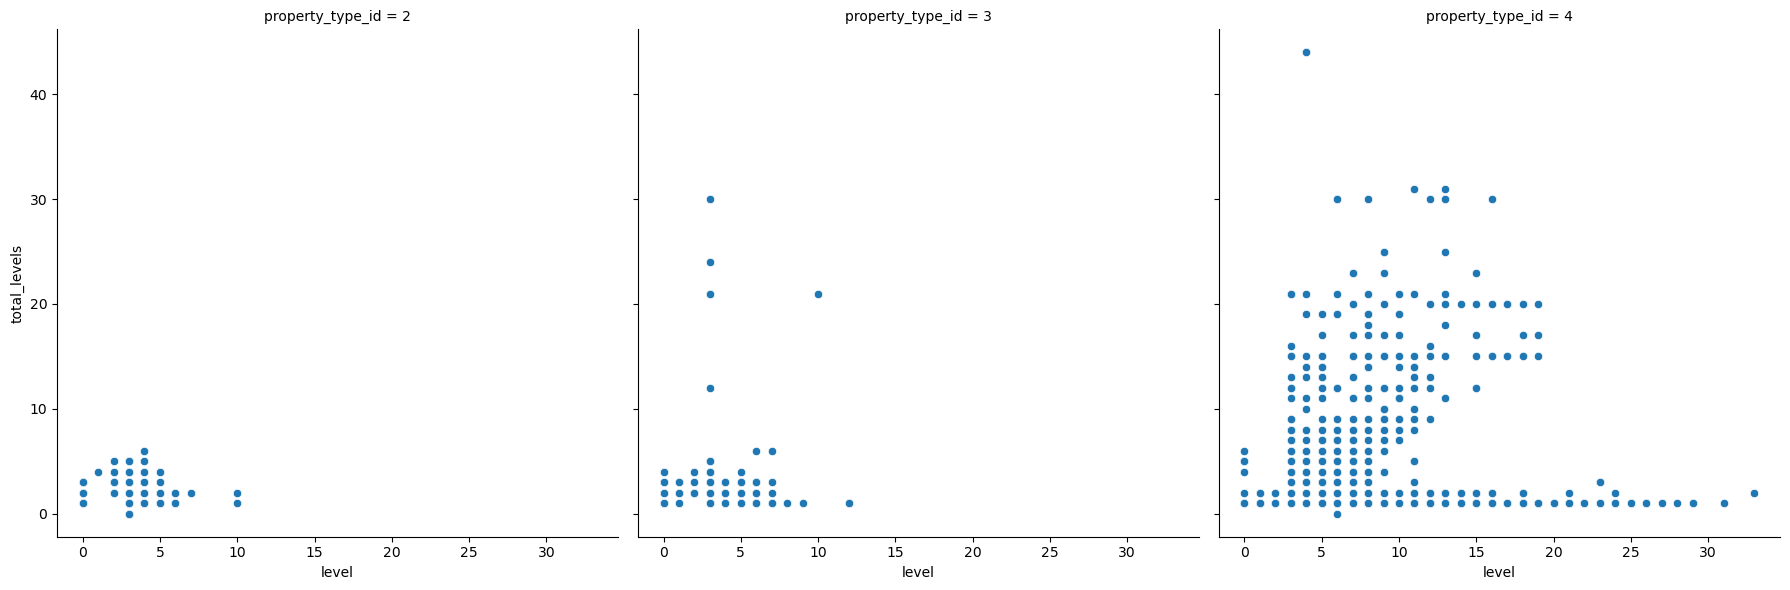

In [14]:
# plot level vs total_levels, facet grid by property_type
g = sns.FacetGrid(gdf_properties, col="property_type_id", height=6)

g.map(
    sns.scatterplot,
    "level",
    "total_levels",
    alpha=1
)

<Axes: ylabel='Frequency'>

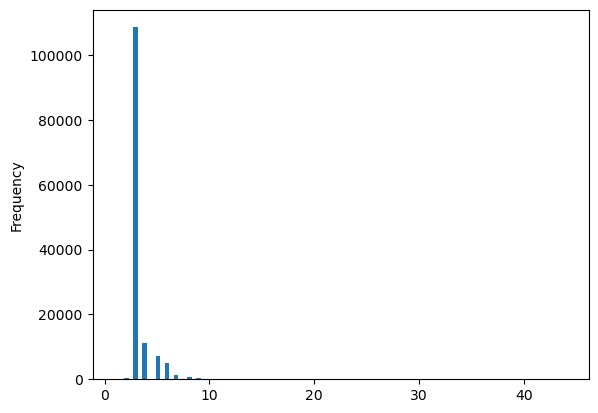

In [19]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1).plot(kind='hist', bins=100)

In [25]:
# histogram of max levels
gdf_properties[['level', 'total_levels']].max(axis=1)

50         3
52         3
60         3
61         3
62         3
          ..
1909852    3
1909907    4
1909935    5
1909936    4
1909937    8
Length: 136194, dtype: uint8